In [13]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from altaipony.fakeflares import aflare

import os
CWD = "/".join(os.getcwd().split("/")[:-2])

import pytest

from funcs.model import (daylength,
                         on_off,
                         lambert,
                         great_circle_distance,
                         dot_ensemble_circular,
                         full_model,
                         lightcurve_model)
from funcs.helper import no_nan_inf
import matplotlib 
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

In [73]:
def xyz(theta, phi):
    return np.cos(theta) * np.sin(phi), np.sin(theta) * np.sin(phi), np.cos(phi)

### Plots 

Text(0, 0.5, 'latitude [deg]')

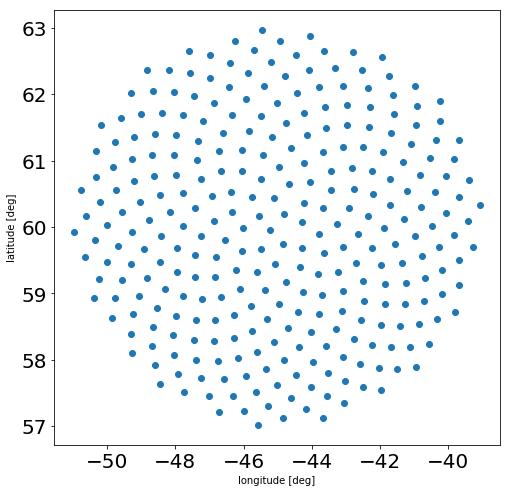

In [153]:
# plot a grid

latdeg = 60
londeg = 45
#latitudes, longitudes = dot_ensemble(np.pi/2-np.pi/8,np.pi/2-np.pi/10,4,num_pts=1e6)
latitudes, longitudes, pos = dot_ensemble_circular(latdeg/180*np.pi,londeg/180*np.pi,3,num_pts=300)
plt.figure(figsize=(8,8))
plt.scatter(longitudes/np.pi*180, latitudes/np.pi*180)
#plt.scatter([180/2-180/10],[180/2-180/8],)
plt.xlabel("longitude [deg]")
plt.ylabel("latitude [deg]")
#plt.savefig(f"{CWD}/analysis/plots/model/dot_ensemble.png",dpi=300)

In [299]:
# Plot a model consisting of an ensemble of rotating flaring points on a sphere
rotation = 100*np.pi/180
incdeg = 40
I = incdeg * np.pi / 180.
phi = np.linspace(0,6*np.pi,2000)
ampl = 20
fwhm = 3.
flare = aflare(phi, rotation, fwhm, ampl,)

lamb, onoff, m = lightcurve_model(phi, latitudes, -longitudes, flare, I)

In [300]:
l=300


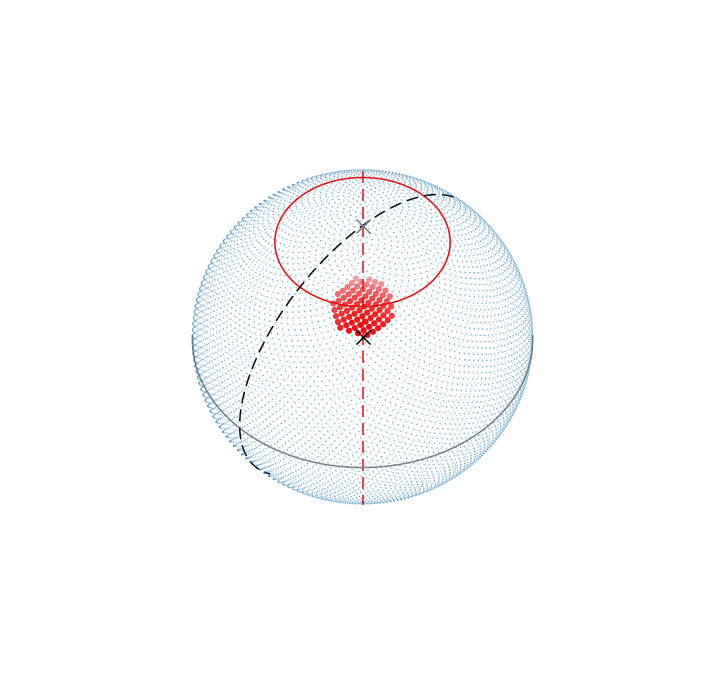

In [307]:
rotation = 405*np.pi/180
# 10% percent area spot on the stellar surface
percent = 10
num_pts=1e4
indices = np.arange(0, num_pts, dtype=float) + 0.5
d = daylength(latdeg/180*np.pi,i=I)


phi = np.arccos(1 - 2*indices/num_pts) #latitude
theta = np.pi * (1 + 5**0.5) * indices  #longitude
a = np.where(great_circle_distance(latdeg/180*np.pi,
                                   londeg*np.pi/180, 
                                   np.pi/2 - phi%(2*np.pi), 
                                   theta%(np.pi*2)) < (percent/180*np.pi))[0]
phi2 = phi[a]
theta2 = theta[a]
x, y, z = np.cos(theta) * np.sin(phi), np.sin(theta) * np.sin(phi), np.cos(phi);
x2, y2, z2 = np.cos(theta2) * np.sin(phi2), np.sin(theta2) * np.sin(phi2), np.cos(phi2);


fig=plt.figure(figsize=(12.4,12.5))
ax=fig.add_subplot(1,1,1,projection="3d")
ax.scatter(x, y, z, s=.1);
ax.scatter(x2, y2, z2, s=25.5, c="r", label="active region");

# active latitude
d = daylength(latdeg/180*np.pi,i=I)
phi = np.full(l,np.pi/2-latdeg*np.pi/180)
theta = np.linspace(-d*np.pi + rotation,d*np.pi + rotation,l)
xtheta, ytheta, ztheta = xyz(theta, phi)
ax.plot(xtheta, ytheta, ztheta, linewidth=1.5, c="r",label=r"$\theta$");

# active longitude
phi = np.full(l,londeg*np.pi/180)
theta = np.linspace(-np.pi, np.pi,l)
a = np.where(great_circle_distance(incdeg/180*np.pi, rotation,
                                   np.pi/2-theta,phi,
                                   ) < (np.pi/2))[0]
theta, phi = theta[a], phi[a]
xtheta, ytheta, ztheta = xyz(phi, theta)
ax.plot(xtheta, ytheta, ztheta, linewidth=1.5, c="r",  dashes=[8,4],
        label=r"$\phi$");





# equator
d = daylength(0,i=I)
phi = np.full(l,np.pi/2-0.01)
theta = np.linspace(-d*np.pi + rotation, d*np.pi + rotation,l)
xtheta, ytheta, ztheta = xyz(theta, phi)
ax.plot(xtheta, ytheta, ztheta, linewidth=1.5, c="grey", label="equator");


# pole
ax.scatter([0,],[0,],[1.,],s=200,c="grey",marker="x",label="rotational pole")

# LOS
theta, phi = [ rotation], [incdeg*np.pi/180]
x, y, z = xyz(theta, phi)
ax.scatter(x,y,z,s=200,c="k",marker="x", label="line of sight")

# t0 longitude
phi = np.full(l,0)
theta = np.linspace(-np.pi, np.pi,l)
a = np.where(great_circle_distance(incdeg/180*np.pi, rotation,
                                   np.pi/2-theta,phi,
                                   ) < (np.pi/2))[0]
theta, phi = theta[a], phi[a]
xtheta, ytheta, ztheta = xyz(phi, theta)
ax.plot(xtheta, ytheta, ztheta,linewidth=1.5, c="k", dashes=[8,4], label=r"$\phi_0$");
#plt.legend(fontsize=16, loc=(0.1,0.75))
plt.axis('off')
ax.view_init(90-incdeg,  rotation*180/np.pi);

plt.savefig(f"{CWD}/analysis/plots/model/10percent_spot_on_a_sphere_flarin_maxrot.png",dpi=300)


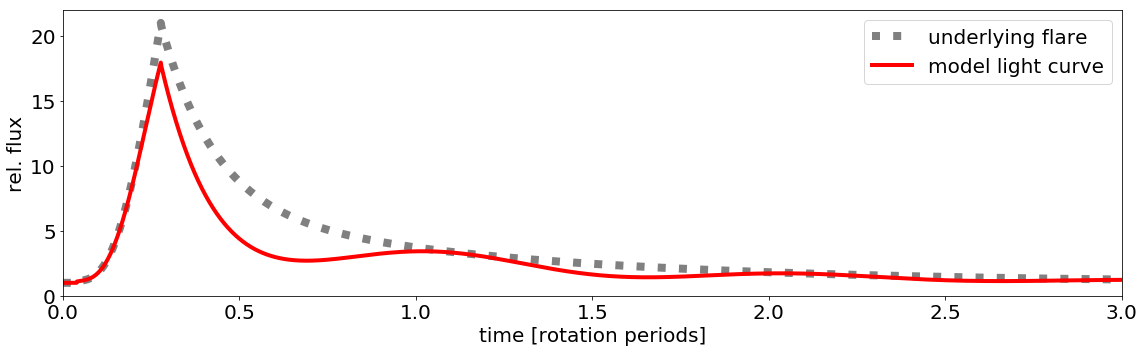

In [313]:
phi = np.linspace(0,6*np.pi,2000)
plt.figure(figsize=(16,5))
# for l,oo in zip(lamb,onoff):
#     plt.plot(phi/2/np.pi, l*oo*flare+1, alpha=.1, c="grey")#,\naverage of individual\ngrid dots (in grey)")
plt.plot(phi/2/np.pi,flare+1, label="underlying flare",c="grey",linestyle="dotted",linewidth=8)
plt.plot(phi/2/np.pi,m+1,linewidth=4, label="model light curve", c="r")
plt.xlabel("time [rotation periods]",fontsize=20)
plt.ylabel("rel. flux",fontsize=20)
plt.xlim(0,3)
plt.legend(fontsize=20)
#plt.yscale("log")
plt.tight_layout()
#plt.title(f"Flare with rel. amplitude={ampl}, and FWHM={fwhm} rotation periods",fontsize=20)
plt.savefig(f"{CWD}/analysis/plots/model/rotating_flare.png",dpi=300);


No handles with labels found to put in legend.


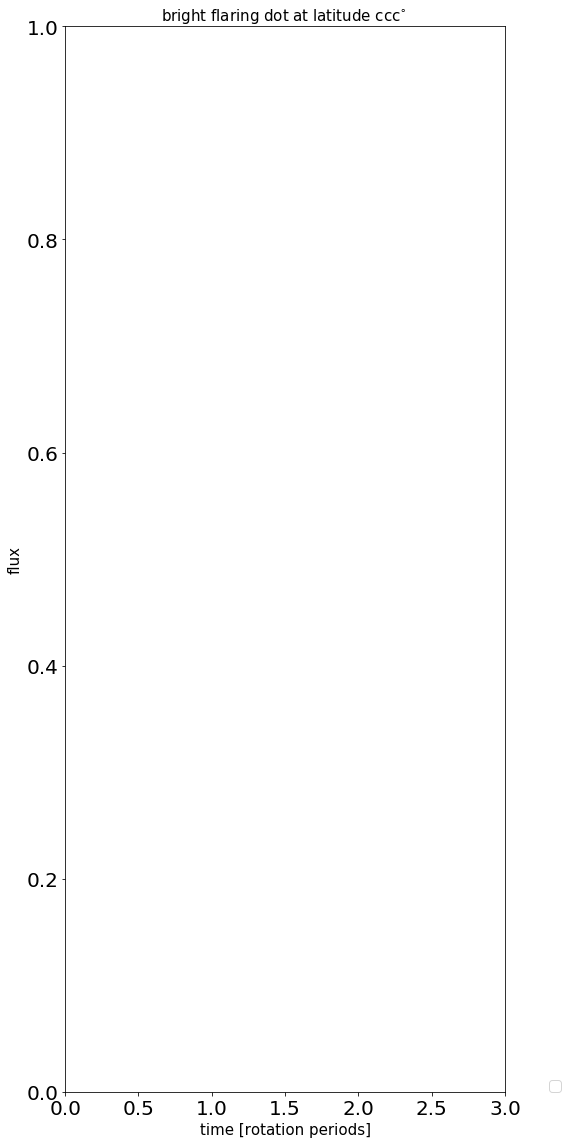

In [294]:
# plot a rotaionally modulated dot-flare
flare = aflare(phi, 1.5, 1.3, 1,)
plt.figure(figsize=(8,16))
l = latdeg/180*np.pi
# I = np.arange(30,91,10)/180*np.pi
# for i in I:
#     D = daylength(l,i)
#     modulation = lambert(phi,i,l)
#     #plt.plot(phi/2/np.pi,modulation*on_off(D,phi),label=f"i={i/np.pi*180:.0f}" + r"$^{\circ}$")
#     plt.plot(phi/2/np.pi,modulation*on_off(phi,D)*flare + i,label=f"i={i/np.pi*180:.0f}" + r"$^{\circ}$",
#             linewidth=2,)
#     plt.plot(phi/2/np.pi,flare + i,c="grey",linestyle="dotted")
plt.title(r"bright flaring dot at latitude ccc$^{\circ}$ ",fontsize=15)
plt.xlabel("time [rotation periods]",fontsize=15)
plt.ylabel("flux",fontsize=15)
plt.legend(loc=(1.1,0),fontsize=15)
plt.xlim(0,3)
plt.tight_layout()
#plt.savefig(f"{CWD}/analysis/plots/model/rotating_bright_dot_flare.png",dpi=300)

In [ ]:
# plot visibility as a function of day time
plt.figure(figsize=(12,4))
phi = np.linspace(0,6*np.pi,500) #(longitude)
daylengths = np.arange(.1,.91,.2)
for d in daylengths:
    plt.plot(phi/2/np.pi, on_off(phi,d), linewidth=d*2,c="k", label=f"day length / Prot={d:.1f}")
plt.legend(loc=(1.05,0))
plt.xlabel("time [days]")
plt.ylabel("visibility")
plt.tight_layout()
#plt.savefig(f"{CWD}/analysis/plots/model/visibility_vs_day.png",dpi=300)

In [ ]:
# Plot daylengths:

I = np.linspace(0,np.pi/2,10)
L = np.linspace(-np.pi/2,np.pi/2, 500)[::-1]
plt.figure(figsize=(10,6))

    
for i in I:
    dl = []
    for l in L:
        dl.append(daylength(l,i))
    plt.plot(L/np.pi*180,dl,label=f"i={i/np.pi*180:.1f}")
plt.xlabel("latitude ",fontsize=15)
plt.ylabel("daylength",fontsize=15)
plt.ylim(-.1,1.1)
plt.xlim(-90,90)
plt.legend(loc=(1.1,0),fontsize=15)
plt.tight_layout()
#plt.savefig(f"{CWD}/analysis/plots/model/daylength.png",dpi=300)